In [1]:
from datasets import load_dataset

import warnings 
warnings.filterwarnings("ignore")


# load dataset with unsplit (400k+ single Rows)
ds = load_dataset("dair-ai/emotion", "unsplit")

In [2]:
# Raw Texts and Labels from Dataset

raw_texts = ds["train"]["text"]
raw_labels = ds["train"]["label"]

In [3]:
import pandas as pd 

df_dict = {
    "text": raw_texts, 
    "label": raw_labels
}

# turn texts and labels into Pandas DataFrame
df = pd.DataFrame(df_dict)
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [4]:
len(df)

416809

In [5]:
# drop Duplicates and NaN's

df = df.drop_duplicates()
df = df.dropna()

len(df)

416123

In [6]:
# create Train DataFrame with 5000 Rows per Label

df_train = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n=5000, random_state=42))
df_train = df_train.sample(frac=1, random_state=42) 

df_train["label"].value_counts()

label
0    5000
4    5000
5    5000
1    5000
2    5000
3    5000
Name: count, dtype: int64

In [7]:
# drop Rows from train_df to avoid data leakage

df_train_index = df_train.index 
df = df.drop(df_train_index)

In [8]:
# validation set with 10000 samples

df_validation = df.sample(n=10000, random_state=42)

df_validation_index = df_validation.index

# drop Rows from validation_df 
df = df.drop(df_validation_index)

In [9]:
# test set with 10000 samples

df_test = df.sample(n=10000, random_state=42)

df_test_index = df_test.index
df = df.drop(df_test_index)

In [10]:
# shuffle all DataFrames and reset the Index

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_validation = df_validation.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

df_train.head()

,text,label
0,i feel numb in my penis at minimum for an hour...,0
1,i feel when the sunlight hits my body makes me...,2
2,i know shes gone and i can still feel how much...,2
3,i feel like i have loved him forever and perha...,2
4,im feeling still a little shocked that i am ev...,5


In [41]:
import os

csvs_save_path = "dataset_csvs/"

# save created splits as csv files (for model building later)
if not os.path.exists(csvs_save_path):
    os.makedirs(csvs_save_path)
    df_train.to_csv(os.path.join(csvs_save_path, "emotion_train.csv"), index=False)
    df_validation.to_csv(os.path.join(csvs_save_path, "emotion_validation.csv"), index=False)
    df_test.to_csv(os.path.join(csvs_save_path, "emotion_test.csv"), index=False)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# get already splitted dataset (to do some model experiments)
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}

# read train split
df_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

In [13]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


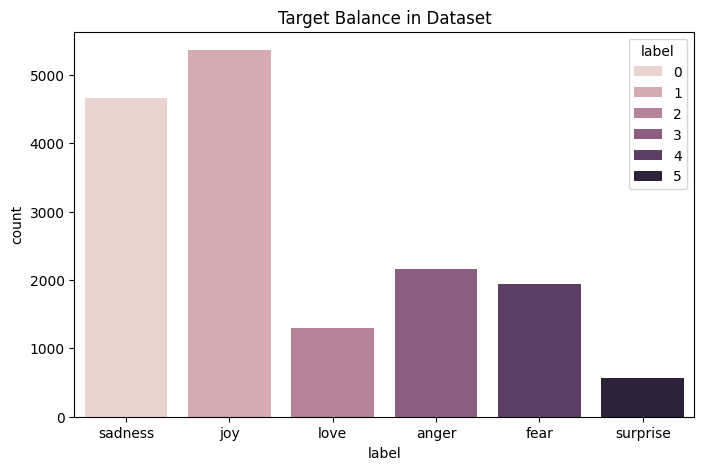

In [14]:
# Check Target Balance in Dataset

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_train, x="label", hue="label")
plt.title("Target Balance in Dataset")
ax.set_xticks([0, 1, 2, 3, 4, 5]) 
ax.set_xticklabels(["sadness", "joy", "love", "anger", "fear", "surprise"])
plt.show()

In [15]:
df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
# Shuffle Datasets

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_validation = df_validation.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
import os 

parquet_save_path = "dataset_parquets/"

if not os.path.exists(parquet_save_path):
    os.makedirs(parquet_save_path)
    df_train.to_parquet(os.path.join(parquet_save_path, "emotion_train.parquet"))
    df_validation.to_parquet(os.path.join(parquet_save_path, "emotion_validation.parquet"))
    df_test.to_parquet(os.path.join(parquet_save_path, "emotion_test.parquet"))

In [18]:
# Create Smaller Train For Testing to see if all works fine

df_train_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_train.parquet"))[:1000]
len(df_train_small)

1000

In [19]:
# Create Smaller Validation for Testing to see if all works fine

df_validation_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_validation.parquet"))[:250]
len(df_validation_small)

250

In [20]:
df_test_small = pd.read_parquet(os.path.join(parquet_save_path, "emotion_test.parquet"))[:250]
len(df_test_small)

250

In [21]:
from datasets import Dataset, DatasetDict

# create transformers Dataset from parquet files
train_dataset = Dataset.from_pandas(df_train_small)
validation_dataset = Dataset.from_pandas(df_validation_small)
test_dataset = Dataset.from_pandas(df_test_small)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [22]:
from transformers import AutoTokenizer

# load tokenizer and preprocess dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True)


tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [23]:
from transformers import TFAutoModelForSequenceClassification


# For Model Config
num_labels = 6
id2label = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}
label2id = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

# load Distilbert Model in Tensorflow Format
model = TFAutoModelForSequenceClassification.from_pretrained(
        "distilbert/distilbert-base-uncased",
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

2024-10-29 16:36:04.798999: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 16:36:04.807343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730216164.817779   87291 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730216164.820797   87291 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 16:36:04.831871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [24]:
from transformers import DataCollatorWithPadding

# for padding strategy
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [25]:
# Prepare Dataset for Tensorflow

tf_train_set = model.prepare_tf_dataset(
        tokenized_dataset["train"],
        shuffle=True,
        batch_size=32,
        collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
        tokenized_dataset["validation"],
        shuffle=False,
        batch_size=32,
        collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
        tokenized_dataset["test"],
        shuffle=False,
        batch_size=32,
        collate_fn=data_collator,
)

In [26]:
from tf_keras.optimizers import Adam 

optimizer = Adam(learning_rate=1e-4)

# compile Model with Optimizer
model.compile(optimizer=optimizer)

In [27]:
import evaluate 
import numpy as np

# Evaluation Metrics on Epoch End

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
    }

In [28]:
from transformers.keras_callbacks import KerasMetricCallback 
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau 

# Callbacks during Training

# stop Training after 8 Epochs no Improvement
early_stopping = EarlyStopping(patience=16, monitor="accuracy", restore_best_weights=True, verbose=1)

# reduce learnrate after 4 Epochs no Improvement
reduce_lr_on_plateau = ReduceLROnPlateau(patience=8, monitor="accuracy", verbose=1)

# calculates Accuracy and F1-Score on Validation Set
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_set
)

In [29]:
# train Model on 15 Epochs

history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=30,
    callbacks=[metric_callback ,early_stopping, reduce_lr_on_plateau],
)

Epoch 1/30


I0000 00:00:1730216175.650140   87622 service.cc:148] XLA service 0x7a1f7c965fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730216175.650160   87622 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-10-29 16:36:15.653379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730216175.661583   87622 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730216175.700464   87622 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 17s 216ms/step - loss: 1.3871 - val_loss: 0.9903 - accuracy: 0.6240 - f1: 0.5381 - lr: 1.0000e-04


2024-10-29 16:36:25.695443: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/30
31/31 [==============================] - 3s 94ms/step - loss: 0.7465 - val_loss: 0.5293 - accuracy: 0.8360 - f1: 0.8281 - lr: 1.0000e-04
Epoch 3/30
 1/31 [..............................] - ETA: 2s - loss: 0.3234

2024-10-29 16:36:28.687354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 3s 84ms/step - loss: 0.3315 - val_loss: 0.3668 - accuracy: 0.9000 - f1: 0.8991 - lr: 1.0000e-04
Epoch 4/30
31/31 [==============================] - 2s 74ms/step - loss: 0.1829 - val_loss: 0.4234 - accuracy: 0.8760 - f1: 0.8764 - lr: 1.0000e-04
Epoch 5/30
 1/31 [..............................] - ETA: 1s - loss: 0.1628

2024-10-29 16:36:33.650335: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 2s 75ms/step - loss: 0.1483 - val_loss: 0.4533 - accuracy: 0.8560 - f1: 0.8574 - lr: 1.0000e-04
Epoch 6/30
31/31 [==============================] - 2s 70ms/step - loss: 0.0854 - val_loss: 0.4673 - accuracy: 0.8720 - f1: 0.8709 - lr: 1.0000e-04
Epoch 7/30
31/31 [==============================] - 2s 70ms/step - loss: 0.0461 - val_loss: 0.5857 - accuracy: 0.8760 - f1: 0.8752 - lr: 1.0000e-04
Epoch 8/30
31/31 [==============================] - 2s 68ms/step - loss: 0.0380 - val_loss: 0.5277 - accuracy: 0.8440 - f1: 0.8483 - lr: 1.0000e-04
Epoch 9/30
 3/31 [=>............................] - ETA: 1s - loss: 0.0597

2024-10-29 16:36:42.410683: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 2s 66ms/step - loss: 0.0300 - val_loss: 0.4680 - accuracy: 0.8840 - f1: 0.8861 - lr: 1.0000e-04
Epoch 10/30
31/31 [==============================] - 2s 71ms/step - loss: 0.0253 - val_loss: 0.4165 - accuracy: 0.9080 - f1: 0.9064 - lr: 1.0000e-04
Epoch 11/30
31/31 [==============================] - 2s 64ms/step - loss: 0.0478 - val_loss: 0.5553 - accuracy: 0.8840 - f1: 0.8828 - lr: 1.0000e-04
Epoch 12/30
31/31 [==============================] - 2s 65ms/step - loss: 0.0401 - val_loss: 0.5705 - accuracy: 0.8880 - f1: 0.8872 - lr: 1.0000e-04
Epoch 13/30
31/31 [==============================] - 2s 63ms/step - loss: 0.0120 - val_loss: 0.5603 - accuracy: 0.8920 - f1: 0.8920 - lr: 1.0000e-04
Epoch 14/30
31/31 [==============================] - 2s 61ms/step - loss: 0.0176 - val_loss: 0.4782 - accuracy: 0.9080 - f1: 0.9084 - lr: 1.0000e-04
Epoch 15/30
31/31 [==============================] - 2s 66ms/step - loss: 0.0437 - val_loss: 0.6701 - accuracy: 0.8600

2024-10-29 16:36:58.576909: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


31/31 [==============================] - 2s 66ms/step - loss: 0.0920 - val_loss: 0.6324 - accuracy: 0.8800 - f1: 0.8780 - lr: 1.0000e-04
Epoch 18/30
31/31 [==============================] - 2s 68ms/step - loss: 0.0311 - val_loss: 0.5249 - accuracy: 0.9120 - f1: 0.9110 - lr: 1.0000e-04
Epoch 19/30
31/31 [==============================] - 2s 60ms/step - loss: 0.0040 - val_loss: 0.5598 - accuracy: 0.9120 - f1: 0.9102 - lr: 1.0000e-04
Epoch 20/30
31/31 [==============================] - 2s 61ms/step - loss: 0.0051 - val_loss: 0.5993 - accuracy: 0.9000 - f1: 0.8976 - lr: 1.0000e-04
Epoch 21/30
31/31 [==============================] - 2s 64ms/step - loss: 0.0458 - val_loss: 0.7329 - accuracy: 0.8640 - f1: 0.8641 - lr: 1.0000e-04
Epoch 22/30
31/31 [==============================] - 2s 61ms/step - loss: 0.0424 - val_loss: 0.7503 - accuracy: 0.8600 - f1: 0.8498 - lr: 1.0000e-04
Epoch 23/30
31/31 [==============================] - 2s 63ms/step - loss: 0.0552 - val_loss: 0.7081 - accuracy: 0.8640

In [43]:
# save Model

model.save_pretrained("./models")

In [44]:
import tensorflow as tf

# testing model

text = "i feel so tired"
correct_label = 0 # sadness 

inputs = tokenizer(text, return_tensors="tf")
logits = model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'sadness'

In [45]:
# load saved model

loaded_model = TFAutoModelForSequenceClassification.from_pretrained("./models")

Some layers from the model checkpoint at ./models were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./models and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
text = "i feel so tired"
correct_label = 0 # sadness 

inputs = tokenizer(text, return_tensors="tf")
logits = loaded_model(**inputs).logits
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
loaded_model.config.id2label[predicted_class_id]

'sadness'

In [33]:
import tensorflow as tf

# Get predicted labels
y_pred_logits = model.predict(tf_test_set).logits
y_pred = tf.math.argmax(y_pred_logits, axis=-1).numpy()  # Convert to numpy array

y_true = df_test_small["label"].values
X_test = df_test_small["text"].values

8/8 [==============================] - 1s 21ms/step


In [34]:
test_acc = accuracy.compute(predictions=y_pred, references=y_true)

# Print accuracy
print("Test Accuracy:", test_acc)

Test Accuracy: {'accuracy': 0.904}


In [38]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)


def classification_evaluation_pipeline(
    X_test: pd.Series,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    classes: list,
    model_history: dict,
    metrics_average: str = "weighted",
    save_folder: str = "save_folder",
) -> None:
    """
    Evaluates the classification model by generating a comprehensive report including classification
    metrics and a confusion matrix. Optionally, it can also return a DataFrame containing incorrect predictions if specified.

    Args:
        X_test (pd.Series): The input text data used for testing the model.
        y_true (np.ndarray): True labels of the test data.
        y_pred (np.ndarray): Predicted labels as returned by the classifier.
        classes (list): List of class names for more interpretable visualizations.
        get_wrong_preds (bool, optional): Flag to determine if the function should return a DataFrame with wrong predictions. Defaults to False.

    Returns:
        None or (pd.DataFrame, pd.DataFrame): If get_wrong_preds is True, returns a tuple of two DataFrames:
            1. DataFrame of the test data, predictions, and true labels.
            2. DataFrame of incorrect predictions only.

    Example usage:
        y_pred = model.predict(X_test)
        classes = ["Class 0", "Class 1"]
        metrics_average = "weighted"
        save_folder = "model_1"
        classification_evaluation_pipeline(X_test=X_test, y_true=y_test, y_pred=y_pred, classes=classes, metrics_average=metrics_average, save_folder=save_folder)
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    print("Plotting Model History")
    plot_model_history(history=model_history, save_folder=save_folder)
    print("Printing Classification Report")
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=classes))
    print("Plotting Classification Report with Support")
    report = classification_report(
        y_pred=y_pred, y_true=y_true, output_dict=True, target_names=classes
    )
    plot_classification_report_with_support(report=report, save_folder=save_folder)
    report_df = pd.DataFrame(report)
    report_df.to_csv(f"{save_folder}/classification_report.csv", index=False)

    print("Plot Confusion Matrix")
    make_confusion_matrix(
        y_true=y_true, y_pred=y_pred, classes=classes, save_folder=save_folder
    )

    print("Getting wrong Predictions.")
    df_predictions, wrong_preds = get_wrong_predictions(
        X_test=X_test,
        y_pred=y_pred,
        y_true=y_true,
        classes=classes,
    )
    df_predictions.to_csv(f"{save_folder}/all_model_predictions.csv", index=False)
    wrong_preds.to_csv(f"{save_folder}/model_wrong_predictions.csv", index=False)

    print("Calculating Accuracy, F1-Score, Precision and Recall")
    df_metrics = calculate_metrics(
        y_pred=y_pred, y_true=y_true, average=metrics_average
    )
    df_metrics.to_csv(f"{save_folder}/model_metrics_{metrics_average}.csv", index=False)


def plot_model_history(history: dict, save_folder: str):  
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    val_accuracy = history.history["accuracy"]
    val_f1 = history.history["f1"]

    lr = history.history["lr"]

    epochs = range(1, len(history.history["loss"]) + 1)  # Start epochs at 1

    # Plotting setup for a vertical layout
    plt.figure(figsize=(10, 10))  # Use provided figure size

    # Plot loss
    plt.subplot(3, 1, 1)  # 2 rows, 1 column, 1st subplot = loss
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(3, 1, 2)  # 2 rows, 1 column, 2nd subplot = f1-score
    plt.plot(epochs, val_f1, label="Validation F1 - Score")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Validation F1 - Score and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("F1 - Score")
    plt.legend()

    # Plot accuracy
    plt.subplot(3, 1, 3)  # 2 rows, 1 column, 2nd subplot = f1-score
    plt.plot(epochs, lr, label="Learning Rate")
    plt.title("Learning Rate over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.legend()

    plt.tight_layout()  # Adjust layout to not overlap
    plt.savefig(f"{save_folder}/model_history.png")
    plt.show()


def plot_classification_report_with_support(report: dict, save_folder: str):
    labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    metrics = ["precision", "recall", "f1-score", "support"]
    data = np.array([[report[label][metric] for metric in metrics] for label in labels])
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.matshow(data, cmap="coolwarm")
    plt.xticks(range(len(metrics)), metrics)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(cax)
    # Adding the text
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="white")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.title("Classification Report with Support")
    plt.savefig(f"{save_folder}/classification_report.png")
    plt.show()


def make_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    save_folder: str,
    classes: np.ndarray = None,
    figsize: tuple[int, int] = (10, 10),
    text_size: int = 15,
    cmap: str = "Blues",
    norm: bool = False,
) -> None:
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels, with options to normalize
    and save the figure.

    Args:
      y_true (np.ndarray): Array of truth labels (must be same shape as y_pred).
      y_pred (np.ndarray): Array of predicted labels (must be same shape as y_true).
      classes (np.ndarray): Array of class labels (e.g., string form). If `None`, integer labels are used.
      figsize (tuple[int, int]): Size of output figure (default=(10, 10)).
      text_size (int): Size of output figure text (default=15).
      norm (bool): If True, normalize the values in the confusion matrix (default=False).
      savefig (bool): If True, save the confusion matrix plot to the current working directory (default=False).

    Returns:
        None: This function does not return a value but displays a Confusion Matrix. Optionally, it saves the plot.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10,
                            norm=True,
                            savefig=True)
    """
    # Create the confusion matrix
    cm = (
        confusion_matrix(y_true, y_pred, normalize="true")
        if norm
        else confusion_matrix(y_true, y_pred)
    )

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    # Set class labels
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(len(cm))

    # Set the labels and titles
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
    )
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Annotate the cells with the appropriate values
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i, j]:.2f}" if norm else f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
            size=text_size,
        )

    plt.tight_layout()
    # Save the figure if requested
    plt.savefig(f"{save_folder}/confusion_matrix.png")
    plt.show()


def get_wrong_predictions(
    X_test: pd.Series,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    classes: list,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Identifies and returns the correct and incorrect predictions made by a classification model.
    The function creates a DataFrame that includes the test inputs, actual and predicted labels, and class names.
    It also visualizes the distribution of correct and incorrect predictions.

    Args:
        X_test (pd.Series): The input text data that was used for testing the model, used here to trace back incorrect predictions to the original inputs.
        y_true (np.ndarray): The actual labels from the test data, representing the true classes of the inputs.
        y_pred (np.ndarray): The predicted labels produced by the classification model, used to compare against the true labels to determine prediction correctness.
        classes (list): A list of class names corresponding to the label indices, used to convert label indices into human-readable class names for easier interpretation and visualization.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames:
            1. The first DataFrame includes all predictions with columns for the text, actual and predicted labels, and whether each prediction was correct.
            2. The second DataFrame is a subset of the first and includes only the rows where the predictions were incorrect.

    The function also plots a count plot showing the balance between correct and incorrect predictions across predicted class labels.
    """
    df_dict = {
        "text": X_test,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_true_classnames": [classes[i] for i in y_true],
        "y_pred_classnames": [classes[i] for i in y_pred],
    }

    df_pred = pd.DataFrame(df_dict).reset_index(drop=True)
    df_pred["pred_correct"] = df_pred["y_true"] == df_pred["y_pred"]

    plt.figure(figsize=(8, 4))
    sns.countplot(x="pred_correct", hue="y_pred_classnames", data=df_pred)
    plt.title("Balance between Predictions")
    plt.show()

    wrong_preds = df_pred[df_pred["pred_correct"] == False].reset_index(drop=True)
    return df_pred, wrong_preds


def calculate_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, average: str = "weighted"
):
    acc_score = accuracy_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true, average=average)
    precision = precision_score(y_pred=y_pred, y_true=y_true, average=average)
    recall = recall_score(y_pred=y_pred, y_true=y_true, average=average)

    df_dict = {
        f"accuracy": acc_score,
        f"f1-score_{average}": f1,
        f"precision_{average}": precision,
        f"recall_{average}": recall,
    }

    df_metrics = pd.DataFrame([df_dict])
    return df_metrics

Plotting Model History


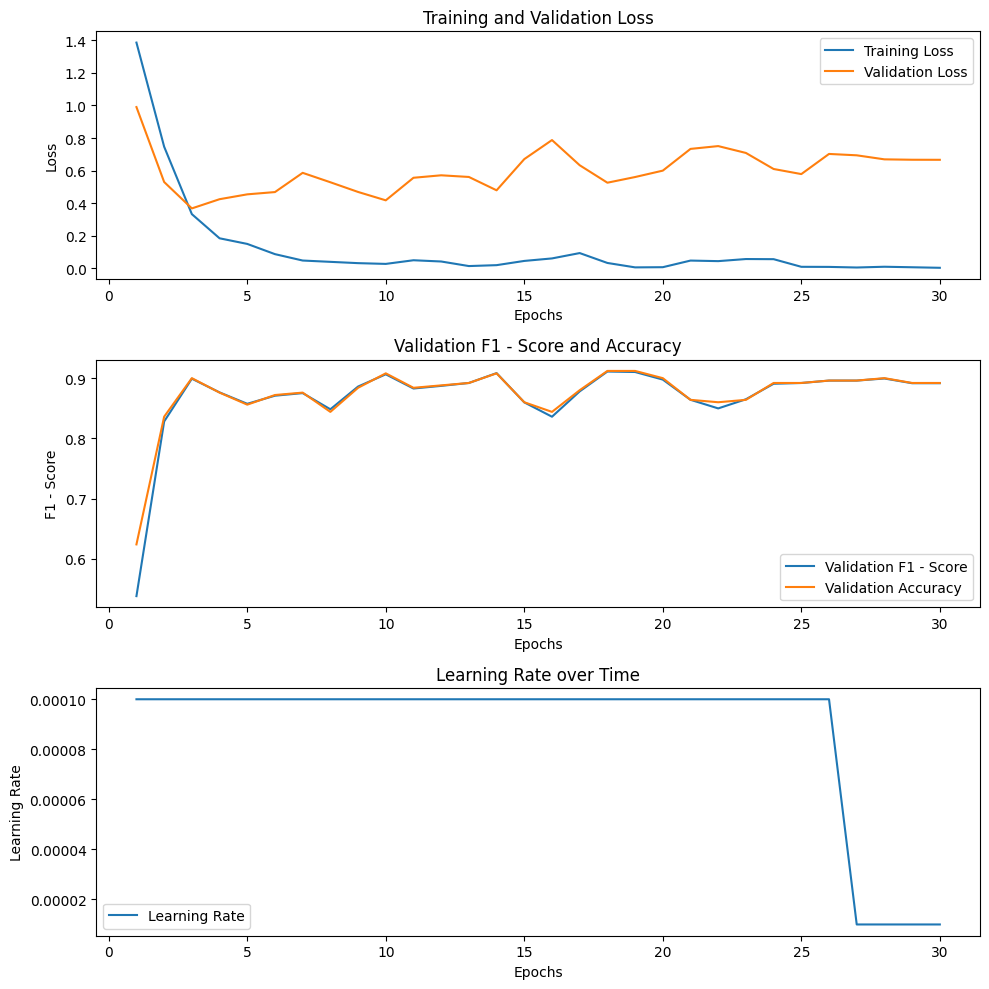

Printing Classification Report
              precision    recall  f1-score   support

     sadness       0.90      0.95      0.92        81
         joy       0.99      0.91      0.95        89
        love       0.80      0.87      0.83        23
       anger       0.80      0.89      0.84        27
        fear       0.89      0.77      0.83        22
    surprise       0.88      0.88      0.88         8

    accuracy                           0.90       250
   macro avg       0.88      0.88      0.87       250
weighted avg       0.91      0.90      0.90       250

Plotting Classification Report with Support


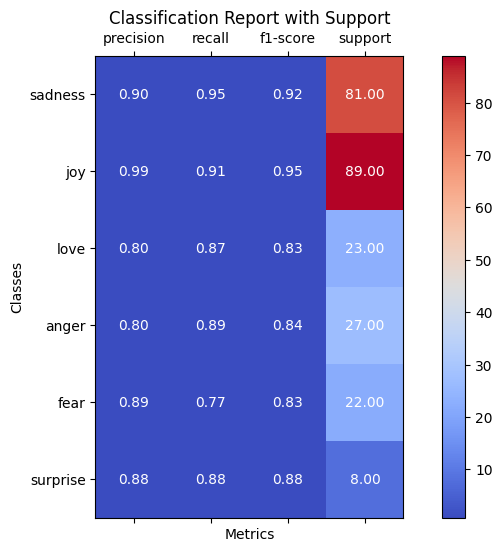

Plot Confusion Matrix


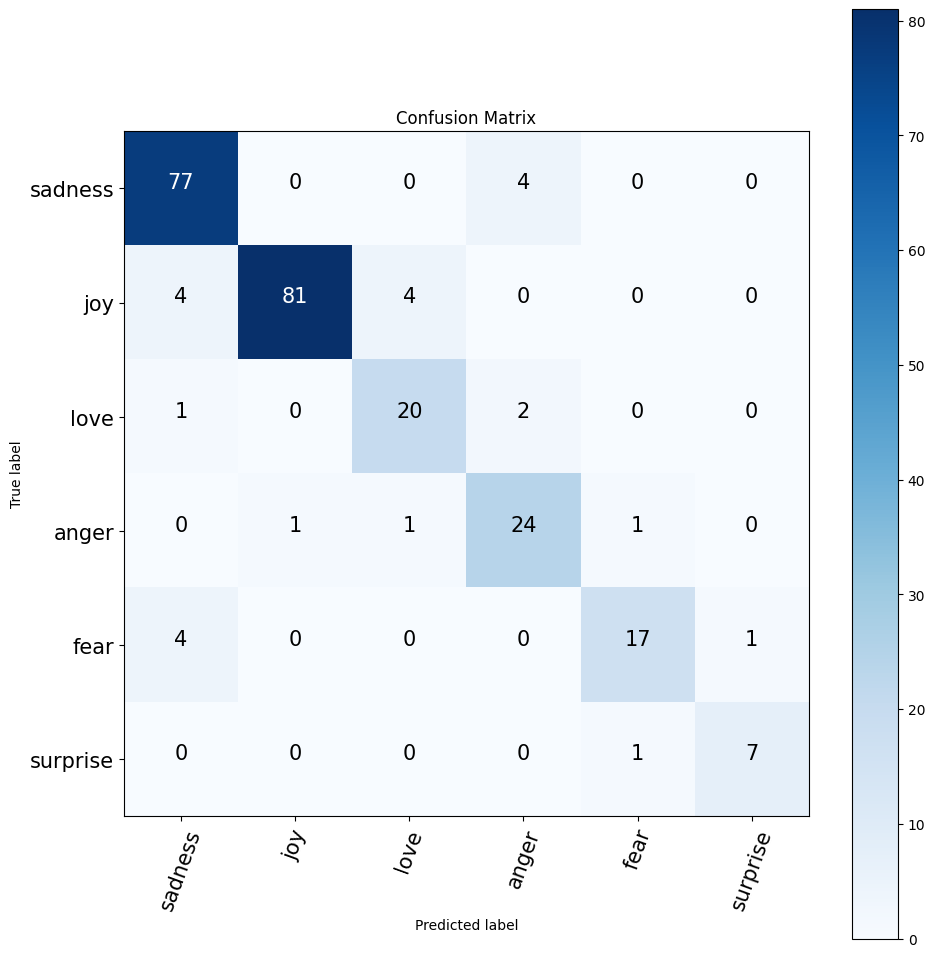

Getting wrong Predictions.


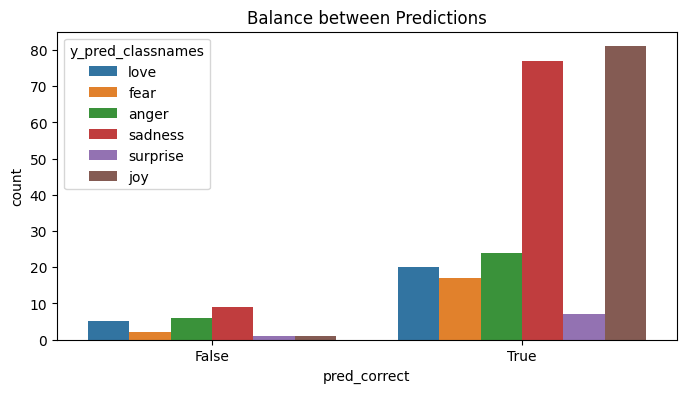

Calculating Accuracy, F1-Score, Precision and Recall


In [39]:
save_folder = "distilbert_evaluation/"
classes = ["sadness", "joy", "love", "anger", "fear", "surprise"]

classification_evaluation_pipeline(save_folder=save_folder, X_test=X_test, y_pred=y_pred, y_true=y_true, classes=classes, model_history=history)

In [37]:
# get wrong predictions csv from evaluation

evaluation_folder = "distilbert_evaluation"
wrong_predictions_csv = os.path.join(evaluation_folder, "model_wrong_predictions.csv")

wrong_predictions_df = pd.read_csv(wrong_predictions_csv)
wrong_predictions_df.head()

,text,y_true,y_pred,y_true_classnames,y_pred_classnames,pred_correct
0,i could feel his breath on me and smell the sw...,1,2,joy,love,False
1,i have felt the need to write out my sometimes...,3,4,anger,fear,False
2,at a party i met a girl who drew me to her,3,2,anger,love,False
3,i feel this strange sort of liberation,5,4,surprise,fear,False
4,i feel a bit like a naughty kid who went and s...,2,3,love,anger,False
